# The TensorFlow way

In [1]:
import tensorflow as tf
print(tf.__version__)

2.1.0


## Recipe 1: Operations in a computational graph

In [2]:
import numpy as np 
x_vals = np.array([1., 3., 5., 7., 9.])
x_data = tf.Variable(x_vals, dtype=tf.float32)
m_const = tf.constant(3.)
operation = tf.multiply(x_data, m_const)
for result in operation:
    print(result.numpy())

3.0
9.0
15.0
21.0
27.0


## Recipe 2: Layering nested operations

In [3]:
import numpy as np 
my_array = np.array([[1., 3., 5., 7., 9.], 
                     [-2., 0., 2., 4., 6.], 
                     [-6., -3., 0., 3., 6.]]) 
x_vals = np.array([my_array, my_array + 1]) 
x_data = tf.Variable(x_vals, dtype=tf.float32) 

In [4]:
m1 = tf.constant([[1.], [0.], [-1.], [2.], [4.]]) 
m2 = tf.constant([[2.]]) 
a1 = tf.constant([[10.]]) 

In [5]:
def prod1(a, b):
    return tf.matmul(a, b)

def prod2(a, b):
    return tf.matmul(a, b) 

def add1(a, b):
    return tf.add(a, b)

In [6]:
result = add1(prod2(prod1(x_data, m1), m2), a1)
print(result.numpy())

[[[102.]
  [ 66.]
  [ 58.]]

 [[114.]
  [ 78.]
  [ 70.]]]


In [7]:
class Operations():  
    def __init__(self, a):
        self.result = a
    def apply(self, func, b):
        self.result = func(self.result, b)
        return self
        
operation = (Operations(a=x_data)
             .apply(prod1, b=m1)
             .apply(prod2, b=m2)
             .apply(add1, b=a1))

print(operation.result.numpy())

[[[102.]
  [ 66.]
  [ 58.]]

 [[114.]
  [ 78.]
  [ 70.]]]


In [8]:
v = tf.Variable(initial_value=tf.random.normal(shape=(1, 5)),
                shape=tf.TensorShape((None, 5)))

v.assign(tf.random.normal(shape=(10, 5)))

<tf.Variable 'UnreadVariable' shape=(None, 5) dtype=float32, numpy=
array([[-0.49064884,  1.5854808 , -0.48412526,  0.529724  , -1.9356607 ],
       [-0.10888588,  0.6427689 , -0.39801282, -2.0490596 , -0.3290038 ],
       [-0.6064022 , -1.0445235 ,  0.99659276, -1.2113512 , -0.7134128 ],
       [-0.8914672 , -0.9983895 , -0.69238764,  0.301262  ,  1.3808763 ],
       [ 0.689694  ,  0.10973665, -1.6349661 ,  1.2353624 ,  0.92520213],
       [ 1.4275634 ,  1.1289065 ,  1.1697044 , -1.1902597 , -0.43475133],
       [ 0.74462193, -0.95711976, -0.9109171 , -0.3551312 ,  0.39289233],
       [-0.04545735, -0.18926524,  2.1708632 , -0.21195933, -0.84519786],
       [-1.6303022 , -0.68441844,  0.7470786 , -3.502721  ,  1.0648485 ],
       [ 1.8621829 , -1.9822499 ,  0.43865147,  1.3832663 , -0.32650405]],
      dtype=float32)>

## Recipe 3: Working with multiple layers

In [9]:
import tensorflow as tf 
import numpy as np 

In [10]:
batch_size = [1]
x_shape = [4, 4, 1]
x_data = tf.random.uniform(shape=batch_size + x_shape)

In [11]:
def mov_avg_layer(x):
    my_filter = tf.constant(0.25, shape=[2, 2, 1, 1]) 
    my_strides = [1, 2, 2, 1] 
    layer = tf.nn.conv2d(x, my_filter, my_strides, 
                         padding='SAME', name='Moving_Avg_Window')
    return layer

In [12]:
def custom_layer(input_matrix): 
        input_matrix_sqeezed = tf.squeeze(input_matrix) 
        A = tf.constant([[1., 2.], [-1., 3.]]) 
        b = tf.constant(1., shape=[2, 2]) 
        temp1 = tf.matmul(A, input_matrix_sqeezed) 
        temp = tf.add(temp1, b) # Ax + b 
        return tf.sigmoid(temp) 

In [13]:
first_layer = mov_avg_layer(x_data) 
second_layer = custom_layer(first_layer)

In [14]:
print(second_layer)

tf.Tensor(
[[0.9562894  0.9011374 ]
 [0.91472375 0.80579144]], shape=(2, 2), dtype=float32)


## Recipe 4: Implementing loss functions

In [15]:
import matplotlib.pyplot as plt

In [16]:
def l2(y_true, y_pred):
    return tf.square(y_true - y_pred) 

In [17]:
def l1(y_true, y_pred):
    return tf.abs(y_true - y_pred)

In [18]:
def phuber1(y_true, y_pred):
    delta1 = tf.constant(0.25) 
    return tf.multiply(tf.square(delta1), tf.sqrt(1. +  
                            tf.square((y_true - y_pred)/delta1)) - 1.) 

def phuber2(y_true, y_pred):
    delta2 = tf.constant(5.) 
    return tf.multiply(tf.square(delta2), tf.sqrt(1. +  
                            tf.square((y_true - y_pred)/delta2)) - 1.) 

In [19]:
def hinge(y_true, y_pred):
    return tf.maximum(0., 1. - tf.multiply(y_true, y_pred))

In [20]:
def xentropy(y_true, y_pred):
    return - tf.multiply(y_true, tf.math.log(y_pred)) - tf.multiply((1. - y_true), tf.math.log(1. - y_pred)) 

In [21]:
def xentropy_sigmoid(y_true, y_pred):
    return tf.nn.sigmoid_cross_entropy_with_logits(labels=y_true, logits=y_pred) 

In [22]:
def xentropy_weighted(y_true, y_pred):
    weight = tf.constant(0.5) 
    return tf.nn.weighted_cross_entropy_with_logits(labels=y_true,
                                                    logits=y_pred,  
                                                    pos_weight=weight)

In [23]:
def softmax_xentropy(y_true, y_pred):
    return tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=y_pred)
    
unscaled_logits = tf.constant([[1., -3., 10.]]) 
target_dist = tf.constant([[0.1, 0.02, 0.88]])
print(softmax_xentropy(y_true=target_dist, y_pred=unscaled_logits))

tf.Tensor([1.1601256], shape=(1,), dtype=float32)


In [24]:
def sparse_xentropy(y_true, y_pred):
    return tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_true,
                                                          logits=y_pred) 

unscaled_logits = tf.constant([[1., -3., 10.]]) 
sparse_target_dist = tf.constant([2]) 
print(sparse_xentropy(y_true=sparse_target_dist, y_pred=unscaled_logits))

tf.Tensor([0.00012564], shape=(1,), dtype=float32)


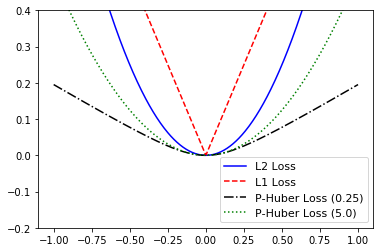

In [25]:
x_vals = tf.linspace(-1., 1., 500) 
target = tf.constant(0.) 

funcs = [(l2, 'b-', 'L2 Loss'),
         (l1, 'r--', 'L1 Loss'),
         (phuber1, 'k-.', 'P-Huber Loss (0.25)'),
         (phuber2, 'g:', 'P-Huber Loss (5.0)')]

for func, line_type, func_name in funcs:
    plt.plot(x_vals, func(y_true=target, y_pred=x_vals), 
             line_type, label=func_name)

plt.ylim(-0.2, 0.4) 
plt.legend(loc='lower right', prop={'size': 11}) 
plt.show()

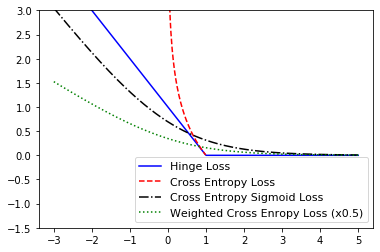

In [26]:
x_vals = tf.linspace(-3., 5., 500)  
target = tf.fill([500,], 1.)

funcs = [(hinge, 'b-', 'Hinge Loss'),
         (xentropy, 'r--', 'Cross Entropy Loss'),
         (xentropy_sigmoid, 'k-.', 'Cross Entropy Sigmoid Loss'),
         (xentropy_weighted, 'g:', 'Weighted Cross Enropy Loss (x0.5)')]

for func, line_type, func_name in funcs:
    plt.plot(x_vals, func(y_true=target, y_pred=x_vals), 
             line_type, label=func_name)
plt.ylim(-1.5, 3) 
plt.legend(loc='lower right', prop={'size': 11}) 
plt.show()

## Recipe 5: Implementing backpropagation

In [27]:
import numpy as np 
import tensorflow as tf 

In [28]:
np.random.seed(0)
x_vals = np.random.normal(1, 0.1, 100).astype(np.float32) 
y_vals = (x_vals * (np.random.normal(1, 0.05, 100) - 0.5)).astype(np.float32)

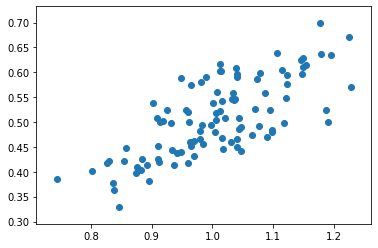

In [29]:
plt.scatter(x_vals, y_vals)
plt.show()

In [30]:
def my_output(X, weights, biases):
    return tf.add(tf.multiply(X, weights), biases)

In [31]:
def loss_func(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_pred - y_true))

In [32]:
my_opt = tf.optimizers.SGD(learning_rate=0.02)

In [33]:
tf.random.set_seed(1)
np.random.seed(0)
weights = tf.Variable(tf.random.normal(shape=[1])) 
biases = tf.Variable(tf.random.normal(shape=[1])) 
history = list()

for i in range(100): 
    rand_index = np.random.choice(100) 
    rand_x = [x_vals[rand_index]] 
    rand_y = [y_vals[rand_index]]
    with tf.GradientTape() as tape:
        predictions = my_output(rand_x, weights, biases)
        loss = loss_func(rand_y, predictions)
    history.append(loss.numpy())
    gradients = tape.gradient(loss, [weights, biases])
    my_opt.apply_gradients(zip(gradients, [weights, biases]))
    if (i + 1) % 25 == 0: 
        print(f'Step # {i+1} Weights: {weights.numpy()} Biases: {biases.numpy()}')
        print(f'Loss = {loss.numpy()}')


Step # 25 Weights: [-0.58009654] Biases: [0.91217995]
Loss = 0.13842473924160004
Step # 50 Weights: [-0.5050226] Biases: [0.9813489]
Loss = 0.006441587582230568
Step # 75 Weights: [-0.4791306] Biases: [0.9942327]
Loss = 0.01728087291121483
Step # 100 Weights: [-0.4777394] Biases: [0.9807473]
Loss = 0.05371852591633797


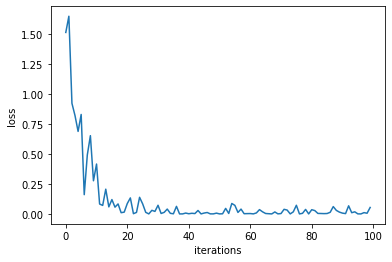

In [34]:
plt.plot(history)
plt.xlabel('iterations')
plt.ylabel('loss')
plt.show()

In [35]:
np.random.seed(0)
x_vals = np.concatenate((np.random.normal(-3, 1, 50), 
                         np.random.normal(3, 1, 50))).astype(np.float32) 
y_vals = np.concatenate((np.repeat(0., 50), np.repeat(1., 50))).astype(np.float32) 

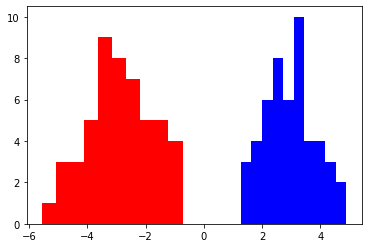

In [36]:
plt.hist(x_vals[y_vals==1], color='b')
plt.hist(x_vals[y_vals==0], color='r')
plt.show()

In [37]:
def loss_func(y_true, y_pred):
    return tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(labels=y_true, 
                                                logits=y_pred))

In [38]:
tf.random.set_seed(1)
np.random.seed(0)
weights = tf.Variable(tf.random.normal(shape=[1])) 
biases = tf.Variable(tf.random.normal(shape=[1])) 
history = list()


for i in range(100):    
    rand_index = np.random.choice(100) 
    rand_x = [x_vals[rand_index]] 
    rand_y = [y_vals[rand_index]]
    with tf.GradientTape() as tape:
        predictions = my_output(rand_x, weights, biases)
        loss = loss_func(rand_y, predictions)
    history.append(loss.numpy())
    gradients = tape.gradient(loss, [weights, biases])
    my_opt.apply_gradients(zip(gradients, [weights, biases]))
    if (i + 1) % 25 == 0: 
        print(f'Step # {i+1} Weights: {weights.numpy()} Biases: {biases.numpy()}')
        print(f'Loss = {loss.numpy()}')

Step # 25 Weights: [-0.0180419] Biases: [0.44081178]
Loss = 0.5967270135879517
Step # 50 Weights: [0.49321094] Biases: [0.3773208]
Loss = 0.3199256658554077
Step # 75 Weights: [0.7071932] Biases: [0.32154968]
Loss = 0.03642747551202774
Step # 100 Weights: [0.8395616] Biases: [0.30409008]
Loss = 0.028119442984461784


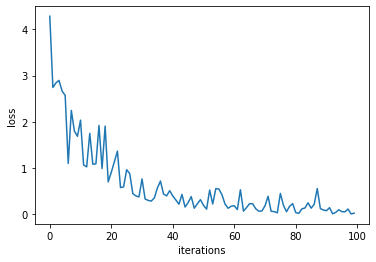

In [39]:
plt.plot(history)
plt.xlabel('iterations')
plt.ylabel('loss')
plt.show()

## Recipe 6: Working with batch and stochastic training

In [40]:
batch_size = 20

In [41]:
np.random.seed(0)
x_vals = np.random.normal(1, 0.1, 100).astype(np.float32) 
y_vals = (x_vals * (np.random.normal(1, 0.05, 100) - 0.5)).astype(np.float32)

In [42]:
def loss_func(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_pred - y_true))

In [43]:
tf.random.set_seed(1)
np.random.seed(0)
weights = tf.Variable(tf.random.normal(shape=[1])) 
biases = tf.Variable(tf.random.normal(shape=[1])) 
history_batch = list()

for i in range(50):    
    rand_index = np.random.choice(100, size=batch_size) 
    rand_x = [x_vals[rand_index]] 
    rand_y = [y_vals[rand_index]]
    with tf.GradientTape() as tape:
        predictions = my_output(rand_x, weights, biases)
        loss = loss_func(rand_y, predictions)
    history_batch.append(loss.numpy())
    gradients = tape.gradient(loss, [weights, biases])
    my_opt.apply_gradients(zip(gradients, [weights, biases]))
    if (i + 1) % 25 == 0: 
        print(f'Step # {i+1} Weights: {weights.numpy()} Biases: {biases.numpy()}')
        print(f'Loss = {loss.numpy()}')

Step # 25 Weights: [-0.55588484] Biases: [0.93091]
Loss = 0.058969467878341675
Step # 50 Weights: [-0.48791304] Biases: [0.9865343]
Loss = 0.01628759130835533


In [44]:
tf.random.set_seed(1)
np.random.seed(0)
weights = tf.Variable(tf.random.normal(shape=[1])) 
biases = tf.Variable(tf.random.normal(shape=[1])) 
history_stochastic = list()

for i in range(50):    
    rand_index = np.random.choice(100, size=1) 
    rand_x = [x_vals[rand_index]] 
    rand_y = [y_vals[rand_index]]
    with tf.GradientTape() as tape:
        predictions = my_output(rand_x, weights, biases)
        loss = loss_func(rand_y, predictions)
    history_stochastic.append(loss.numpy())
    gradients = tape.gradient(loss, [weights, biases])
    my_opt.apply_gradients(zip(gradients, [weights, biases]))
    if (i + 1) % 25 == 0: 
        print(f'Step # {i+1} Weights: {weights.numpy()} Biases: {biases.numpy()}')
        print(f'Loss = {loss.numpy()}')

Step # 25 Weights: [-0.58009654] Biases: [0.91217995]
Loss = 0.13842473924160004
Step # 50 Weights: [-0.5050226] Biases: [0.9813489]
Loss = 0.006441587582230568


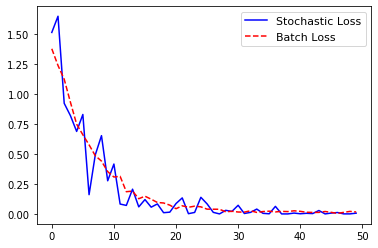

In [45]:
plt.plot(history_stochastic, 'b-', label='Stochastic Loss') 
plt.plot(history_batch, 'r--', label='Batch Loss') 
plt.legend(loc='upper right', prop={'size': 11}) 
plt.show() 

## Recipe 7: Combining everything together

In [46]:
import tensorflow_datasets as tfds
iris = tfds.load('iris', split='train[:90%]', as_supervised=True)
iris_test = tfds.load('iris', split='train[90%:]', as_supervised=True)

In [47]:
batch_size = 20

In [48]:
def iris2d(features, label):
    return features[2:], tf.cast((label == 0), dtype=tf.float32)

train_generator = (iris
                   .map(iris2d)
                   .shuffle(buffer_size=100)
                   .batch(batch_size)
                  )

test_generator = iris_test.map(iris2d).batch(1)

In [49]:
def linear_model(X, A, b):
    my_output = tf.add(tf.matmul(X, A), b) 
    return tf.squeeze(my_output)

In [50]:
def xentropy(y_true, y_pred):
    return tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(labels=y_true, logits=y_pred))

In [51]:
my_opt = tf.optimizers.SGD(learning_rate=0.02)

In [52]:
tf.random.set_seed(1)

np.random.seed(0)
A = tf.Variable(tf.random.normal(shape=[2, 1])) 
b = tf.Variable(tf.random.normal(shape=[1]))
history = list()

for i in range(300):
    iteration_loss = list()
    for features, label in train_generator:
        with tf.GradientTape() as tape:
            predictions = linear_model(features, A, b)
            loss = xentropy(label, predictions)
        iteration_loss.append(loss.numpy())
        gradients = tape.gradient(loss, [A, b])
        my_opt.apply_gradients(zip(gradients, [A, b]))
    history.append(np.mean(iteration_loss))
    if (i + 1) % 30 == 0:
        print(f'Step # {i+1} Weights: {A.numpy().T} Biases: {b.numpy()}')
        print(f'Loss = {loss.numpy()}')

Step # 30 Weights: [[-1.1206311  1.2985772]] Biases: [1.0116111]
Loss = 0.4503694772720337
Step # 60 Weights: [[-1.1845942  1.078174 ]] Biases: [1.5116861]
Loss = 0.2655593752861023
Step # 90 Weights: [[-1.2435986  0.8919205]] Biases: [1.9333057]
Loss = 0.23168331384658813
Step # 120 Weights: [[-1.3032022   0.73274297]] Biases: [2.288856]
Loss = 0.20858512818813324
Step # 150 Weights: [[-1.3522184   0.59674555]] Biases: [2.598111]
Loss = 0.17041867971420288
Step # 180 Weights: [[-1.4021969  0.4764488]] Biases: [2.8675659]
Loss = 0.16567659378051758
Step # 210 Weights: [[-1.4451694   0.37053958]] Biases: [3.1074162]
Loss = 0.1580955982208252
Step # 240 Weights: [[-1.4871405  0.2752318]] Biases: [3.3213842]
Loss = 0.09357322007417679
Step # 270 Weights: [[-1.5251722   0.18946362]] Biases: [3.5148227]
Loss = 0.14454668760299683
Step # 300 Weights: [[-1.5611029   0.11102282]] Biases: [3.6908474]
Loss = 0.10326375812292099


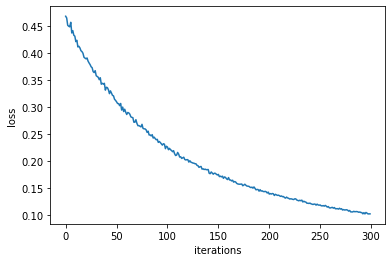

In [53]:
plt.plot(history)
plt.xlabel('iterations')
plt.ylabel('loss')
plt.show()

In [56]:
predictions = list()
labels = list()
for features, label in test_generator:
    predictions.append(linear_model(features, A, b).numpy())
    labels.append(label.numpy()[0])
    
test_loss = xentropy(np.array(labels), np.array(predictions)).numpy()
print(f"test cross-entropy is {test_loss}")

test cross-entropy is 0.10227929800748825


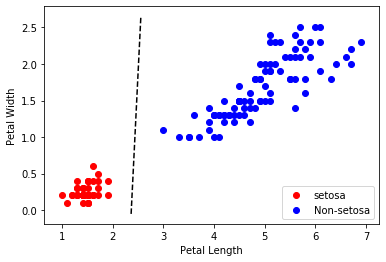

In [55]:
coefficients = np.ravel(A.numpy())
intercept = b.numpy()

# Plotting batches of examples
for j, (features, label) in enumerate(train_generator):
    setosa_mask = label.numpy() == 1
    setosa = features.numpy()[setosa_mask]
    non_setosa = features.numpy()[~setosa_mask]
    plt.scatter(setosa[:,0], setosa[:,1], c='red', label='setosa')
    plt.scatter(non_setosa[:,0], non_setosa[:,1], c='blue', label='Non-setosa')
    if j==0:
        plt.legend(loc='lower right')

# Computing and plotting the decision function
a = -coefficients[0] / coefficients[1]
xx = np.linspace(plt.xlim()[0], plt.xlim()[1], num=10000)
yy = a * xx - intercept / coefficients[1]
on_the_plot = (yy > plt.ylim()[0]) & (yy < plt.ylim()[1])
plt.plot(xx[on_the_plot], yy[on_the_plot], 'k--')

plt.xlabel('Petal Length') 
plt.ylabel('Petal Width') 
plt.show()